In [1]:
library(SoupX)
library(ggplot2)
library(cowplot)
library(SingleR)
library(celldex)
library(Seurat)
library(SummarizedExperiment)
library(scran)
library(patchwork)
library(EnhancedVolcano)
library(clusterProfiler)
library(org.Mm.eg.db)
library(AnnotationHub)
library(dplyr)
library(enrichplot)
library(SingleCellExperiment)
library("reshape2")
library(viridis)
library(harmony)
#############################################
# COMMENTS
#############################################
# Needs to fix... 
# directory paths
# parameters for statistics

# toc: Table of counts (filtered). Just those columns of \code{tod} that contain cells.
# tod: Table of droplets (raw).  A matrix with columns being each droplet and rows each gene.

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

ERROR: Error in library(EnhancedVolcano): there is no package called ‘EnhancedVolcano’


2967 genes passed tf-idf cut-off and 1087 soup quantile filter.  Taking the top 100.

Using 472 independent estimates of rho.

Estimated global rho of 0.03

Warning message in sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w], :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Expanding counts from 13 clusters to 8677 cells.

5117 genes passed tf-idf cut-off and 1720 soup quantile filter.  Taking the top 100.

Using 684 independent estimates of rho.

Estimated global rho of 0.04



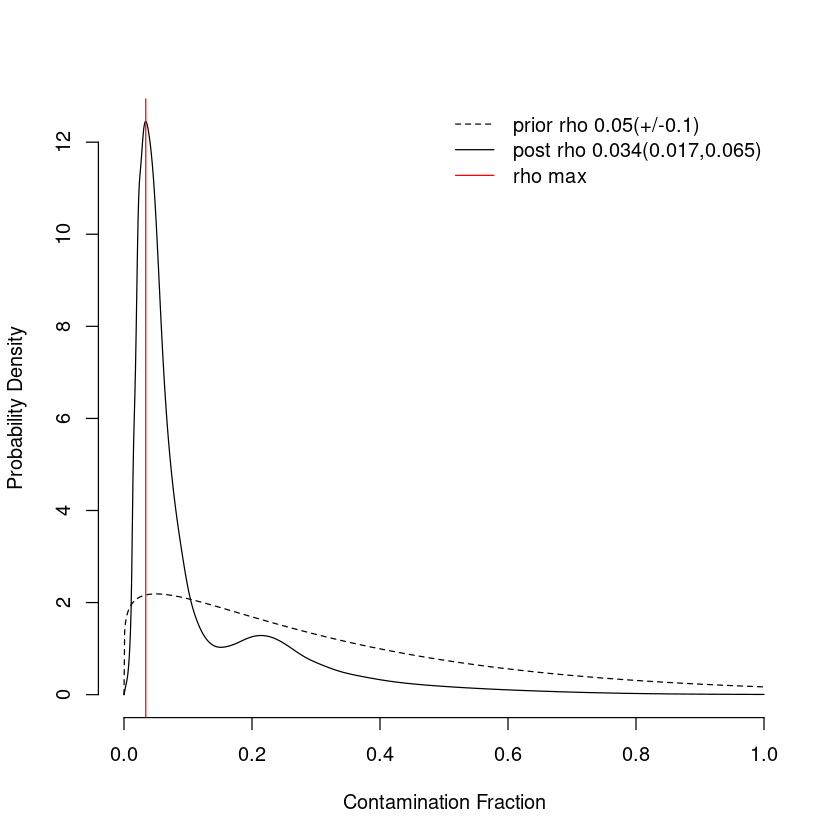

Warning message in sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w], :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Expanding counts from 16 clusters to 10377 cells.



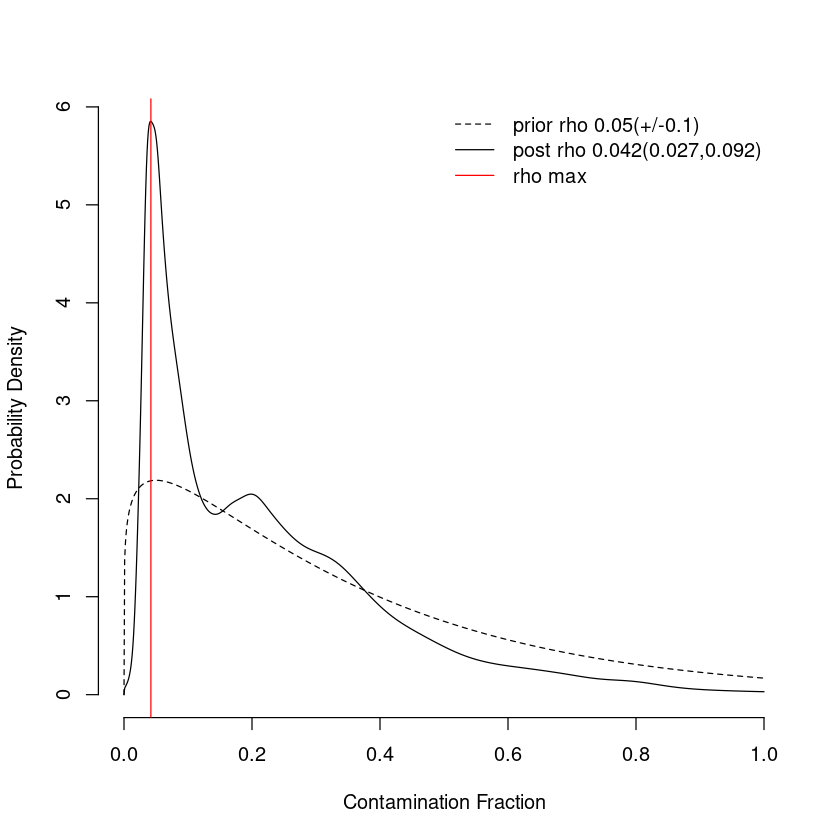

In [3]:
#REMOVE BACKGROUND IN adj
adj_toc = Read10X(data.dir ="../outs_cellranger6/adj/outs/filtered_feature_bc_matrix")
adj_tod = Read10X(data.dir ="../outs_cellranger6/adj/outs/raw_feature_bc_matrix")
adj_sc = SoupChannel(adj_tod, adj_toc)
adj_sc = SoupChannel(adj_tod, adj_toc, calcSoupProfile = FALSE)
adj_sc = estimateSoup(adj_sc)
adj_metadata <-read.csv(file ="../outs_cellranger6/adj/outs/analysis/clustering/graphclust/clusters.csv")
adj_sc = setClusters(adj_sc, setNames(adj_metadata$Cluster, rownames(adj_metadata)))
# Estimate rho
adj_sc = autoEstCont(adj_sc)
# Clean the data
adj_out = adjustCounts(adj_sc)

#REMOVE BACKGROUND IN dpi4
dpi4_toc = Read10X(data.dir ="../outs_cellranger6/dpi4/outs/filtered_feature_bc_matrix")
dpi4_tod = Read10X(data.dir ="../outs_cellranger6/dpi4/outs/raw_feature_bc_matrix")
dpi4_sc = SoupChannel(dpi4_tod, dpi4_toc)
dpi4_sc = SoupChannel(dpi4_tod, dpi4_toc, calcSoupProfile = FALSE)
dpi4_sc = estimateSoup(dpi4_sc)
dpi4_metadata <-read.csv(file ="../outs_cellranger6/dpi4/outs/analysis/clustering/graphclust/clusters.csv")
dpi4_sc = setClusters(dpi4_sc, setNames(dpi4_metadata$Cluster, rownames(dpi4_metadata)))
# Estimate rho
dpi4_sc = autoEstCont(dpi4_sc)
# Clean the data
dpi4_out = adjustCounts(dpi4_sc)

In [4]:
# Set up adj object
adj <- CreateSeuratObject(counts = adj_out, project = "adj", min.cells = 5)
adj$group <- "adj"
adj <- subset(adj, subset = nFeature_RNA > 500)
adj <- NormalizeData(adj, verbose = FALSE)
adj <- FindVariableFeatures(adj, selection.method = "vst", nfeatures = 2000)
## Hang added##
## Remove Gm42418 (rRNA gene) and AY036118 (long non-coding RNA) from adj
counts.adj <- GetAssayData(adj, assay = "RNA")
counts.adj <- counts.adj[-(which(rownames(counts.adj) %in% c("Gm42418", "AY036118"))),]
adj <- subset(adj, features = rownames(counts.adj))

# Set up dpi4 object
dpi4 <- CreateSeuratObject(counts = dpi4_out, project = "dpi4", min.cells = 5)
dpi4$group <- "dpi4"
dpi4 <- subset(dpi4, subset = nFeature_RNA > 500)
dpi4 <- NormalizeData(dpi4, verbose = FALSE)
dpi4 <- FindVariableFeatures(dpi4, selection.method = "vst", nfeatures = 2000)

## Hang added##
## Remove Gm42418 (rRNA gene) and AY036118 (long non-coding RNA) from dpi4
counts.dpi4 <- GetAssayData(dpi4, assay = "RNA")
counts.dpi4 <- counts.dpi4[-(which(rownames(counts.dpi4) %in% c("Gm42418", "AY036118"))),]
dpi4 <- subset(dpi4, features = rownames(counts.dpi4))

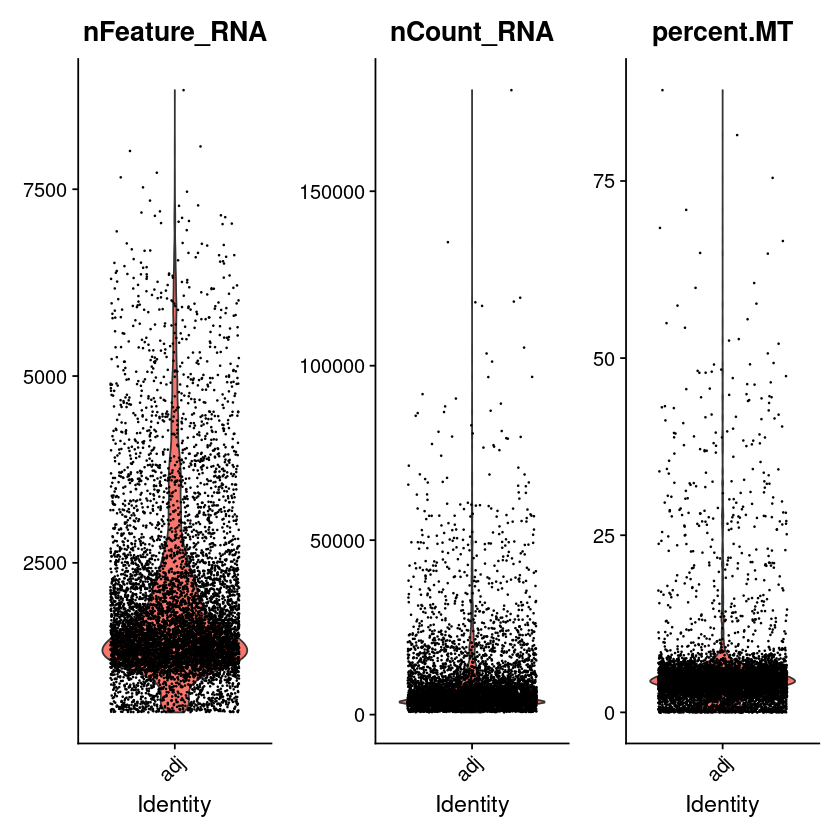

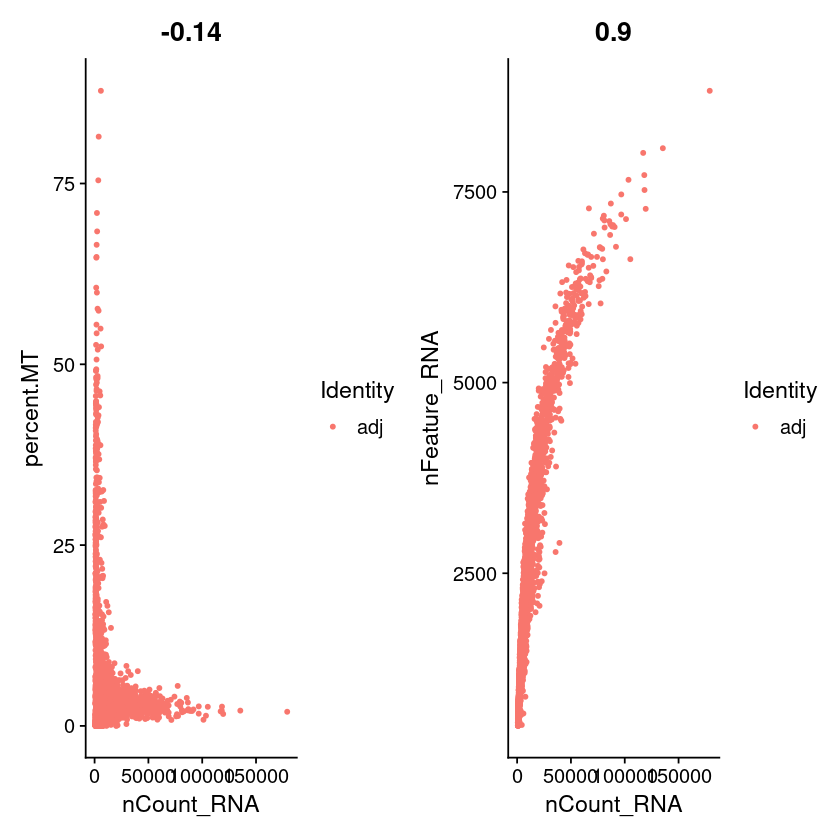

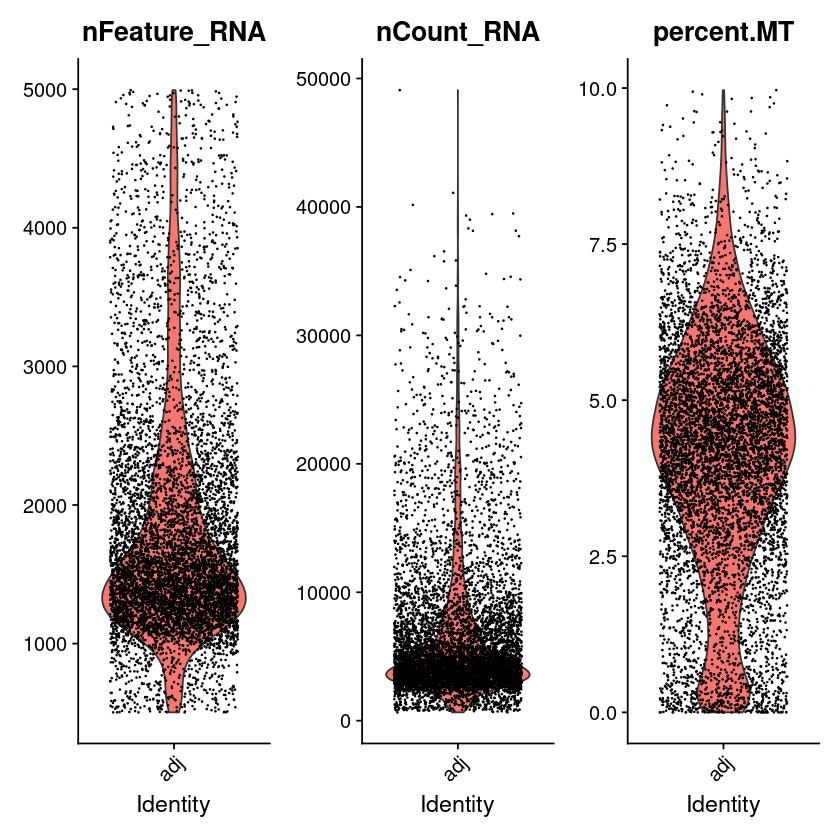

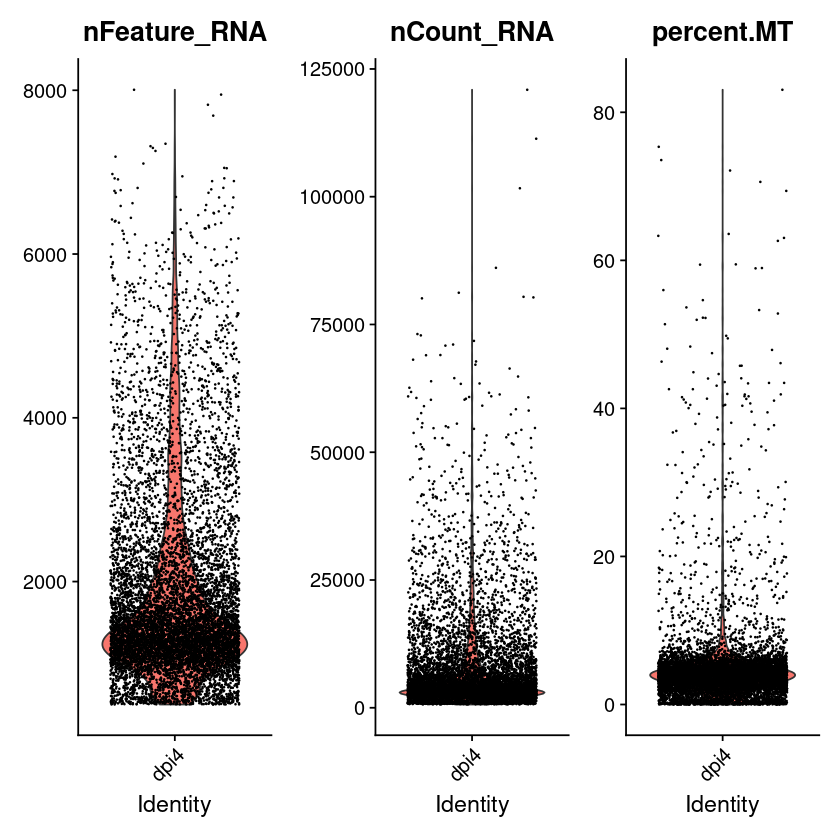

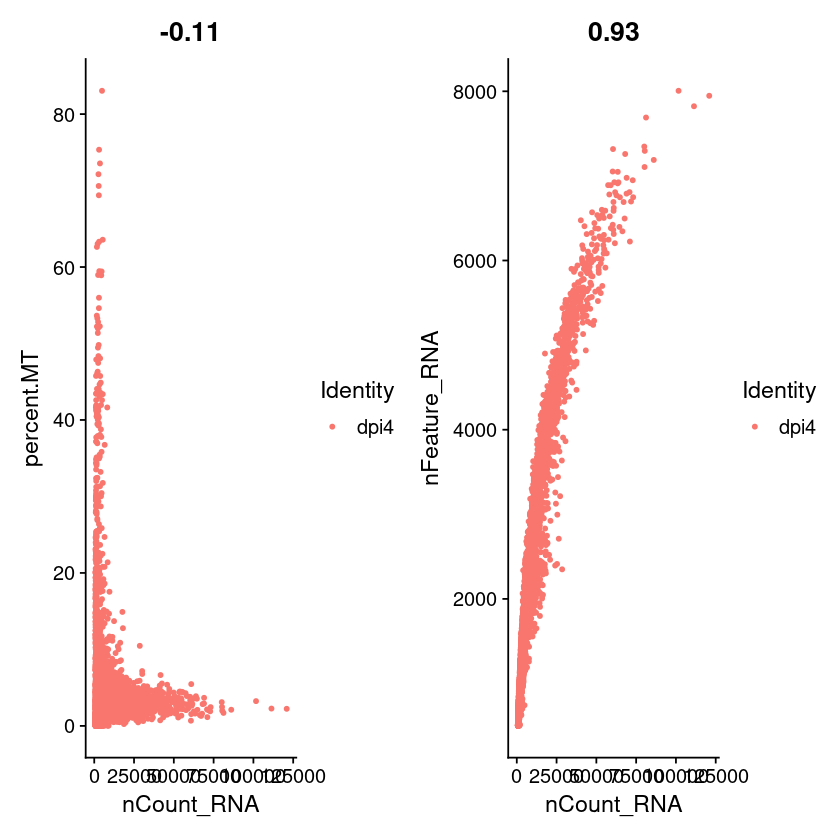

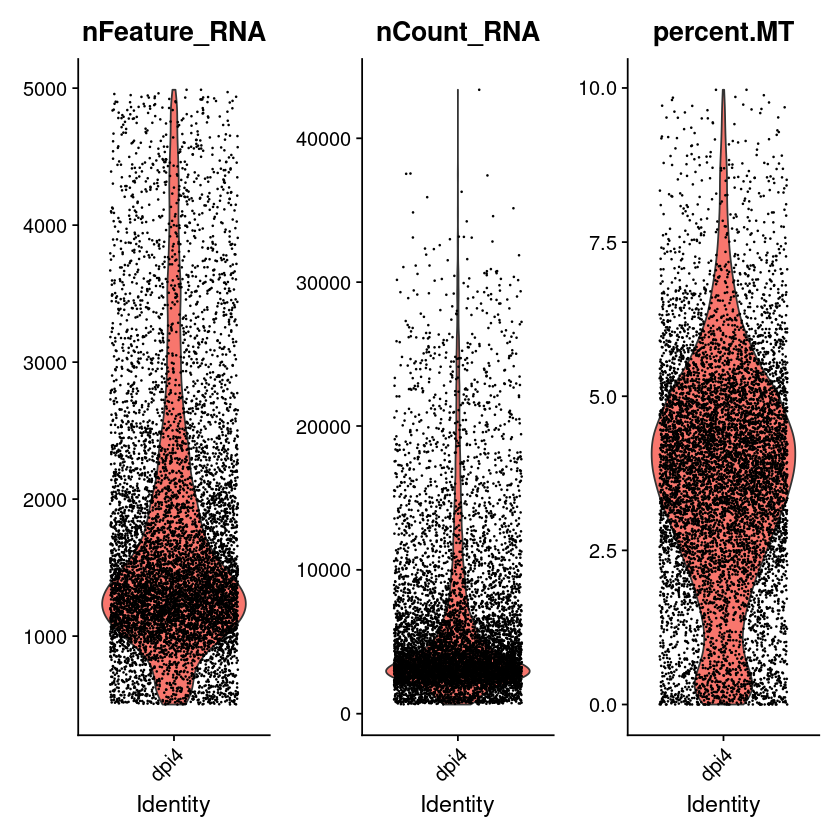

In [5]:
# QUALITY CONTROL adj
adj[["percent.MT"]] <- PercentageFeatureSet(adj, pattern = "^mt-")
VlnPlot(adj, features = c("nFeature_RNA", "nCount_RNA", "percent.MT"), ncol = 3)
plot1 <- FeatureScatter(adj, feature1 = "nCount_RNA", feature2 = "percent.MT")
plot2 <- FeatureScatter(adj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2 
adj <- subset(adj, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.MT < 10)
VlnPlot(adj, features = c("nFeature_RNA", "nCount_RNA", "percent.MT"), ncol = 3)

# QUALITY CONTROL dpi4
dpi4[["percent.MT"]] <- PercentageFeatureSet(dpi4, pattern = "^mt-")
VlnPlot(dpi4, features = c("nFeature_RNA", "nCount_RNA", "percent.MT"), ncol = 3)
plot3 <- FeatureScatter(dpi4, feature1 = "nCount_RNA", feature2 = "percent.MT")
plot4 <- FeatureScatter(dpi4, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 + plot4 
dpi4 <- subset(dpi4, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.MT < 10)
VlnPlot(dpi4, features = c("nFeature_RNA", "nCount_RNA", "percent.MT"), ncol = 3)

In [6]:
###Hang added### 
### Remove batch effects by Harmony
### iterates until similar cells are clustered using PCA for dimensionality reduction.

combine <- merge(adj, y = dpi4, add.cell.ids = c("adj", "dpi4"), project = "PYK")
combine
combine <- NormalizeData(combine) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose = FALSE)
options(repr.plot.height = 5, repr.plot.width = 12)
p1 <- DimPlot(object = combine, reduction = "pca", pt.size = .1, group.by = "orig.ident")
p2 <- VlnPlot(object = combine, features = "PC_2", group.by = "orig.ident",  pt.size = .1)
plot_grid(p1,p2)
options(repr.plot.height = 2.5, repr.plot.width = 6)
combine <- combine %>% 
  RunHarmony("orig.ident", plot_convergence = TRUE)
harmony_embeddings <- Embeddings(combine, 'harmony')
options(repr.plot.height = 5, repr.plot.width = 12)
p1 <- DimPlot(object = combine, reduction = "pca", pt.size = .1, group.by = "orig.ident")
p2 <- VlnPlot(object = combine, features = "PC_1", group.by = "orig.ident",  pt.size = .1)
plot_grid(p1,p2)
combine <- combine %>% 
  RunUMAP(reduction = "harmony", dims = 1:30) %>% 
  FindNeighbors(reduction = "harmony", dims = 1:30) %>% 
  FindClusters(resolution = 0.5) %>% 
  identity()
options(repr.plot.height = 4, repr.plot.width = 10)
DimPlot(combine, reduction = "umap", group.by = "orig.ident", pt.size = .1)

An object of class Seurat 
16517 features across 15421 samples within 1 assay 
Active assay: RNA (16517 features, 0 variable features)

ERROR: Error in NormalizeData(combine) %>% FindVariableFeatures() %>% ScaleData() %>% : could not find function "%>%"
